In [ ]:
import requests
import time
import json
import logging
from datetime import datetime
from multiprocessing import Process, Manager

# Configure logging
def setup_logging(process_id):
    logging.basicConfig(
        filename=f"tmdb_fetch_process_{process_id}_{datetime.now().strftime('%Y%m%d_%H%M%S')}.log",
        level=logging.INFO,
        format="%(asctime)s - %(levelname)s - %(message)s"
    )

API_KEYS = [
    '4c9f1b20ca0112fbc65112d04e968520',
    'c0bbd8a13de8f0ac309d5b9621920ba3',
    '752035b72485becd49355ff7fdb939de'
]

GENRE_IDS = {
    "horror": 27
}

BASE_URL = 'https://api.themoviedb.org/3'
IMAGE_BASE_URL = 'https://image.tmdb.org/t/p/w500'
REQUESTS_PER_10_SECONDS = 40
SECONDS_PER_WINDOW = 10
REQUEST_INTERVAL = SECONDS_PER_WINDOW / REQUESTS_PER_10_SECONDS

START_YEAR = 1965
END_YEAR = 1984


def rate_limit(request_count, window_start):
    request_count += 1
    elapsed = time.time() - window_start
    if request_count >= REQUESTS_PER_10_SECONDS:
        if elapsed < SECONDS_PER_WINDOW:
            time.sleep(SECONDS_PER_WINDOW - elapsed)
        request_count = 0
        window_start = time.time()
    else:
        time.sleep(REQUEST_INTERVAL)
    return request_count, window_start


def safe_request(url, params, api_key, request_count, window_start, retries=3):
    for attempt in range(retries):
        params["api_key"] = api_key
        request_count, window_start = rate_limit(request_count, window_start)
        try:
            response = requests.get(url, params=params, timeout=10)
            if response.status_code == 200:
                return response, request_count, window_start
            elif response.status_code == 429:
                logging.warning("Rate limit hit (429). Waiting...")
                time.sleep(10)
            else:
                logging.error(f"Request failed with status {response.status_code}")
        except requests.RequestException as e:
            logging.error(f"Request error: {e}")
        time.sleep(0.5)
    logging.error(f"All retries failed for URL: {url}")
    return None, request_count, window_start


def get_primary_genre(genres):
    return genres[0]['name'] if genres else None


def get_movies_by_genre(page, genre_id, api_key, request_count, window_start, year):
    url = f"{BASE_URL}/discover/movie"
    params = {
        "language": "en-US",
        "page": page,
        "with_genres": genre_id,
        "sort_by": "popularity.desc",
        "primary_release_year": year
    }
    return safe_request(url, params, api_key, request_count, window_start)


def get_movie_details(movie_id, api_key, request_count, window_start):
    url = f"{BASE_URL}/movie/{movie_id}"
    params = {"language": "en-US"}
    response, request_count, window_start = safe_request(url, params, api_key, request_count, window_start)
    if response:
        data = response.json()
        return {
            "id": data.get("id"),
            "title": data.get("title"),
            "overview": data.get("overview"),
            "poster_url": IMAGE_BASE_URL + data["poster_path"] if data.get("poster_path") else None,
            "primary_genre": get_primary_genre(data.get("genres", []))
        }, request_count, window_start
    return None, request_count, window_start


def collect_genre_movies(genre, genre_id, api_key, process_id, shared_data):
    setup_logging(process_id)
    request_count = 0
    window_start = time.time()
    seen_ids = set()

    logging.info(f"[Process {process_id}] Fetching movies for genre {genre}")
    print(f"[Process {process_id}] Fetching movies for genre {genre}...")

    for year in range(START_YEAR, END_YEAR + 1):
        if len(shared_data) >= 10000:
            break
        page = 1
        while len(shared_data) < 10000:
            logging.info(f"[Process {process_id}] Year {year}, Page {page} for genre {genre}")
            print(f"[Process {process_id}] Year {year}, Page {page} for genre {genre}...")
            response, request_count, window_start = get_movies_by_genre(page, genre_id, api_key, request_count, window_start, year)
            if not response:
                break
            movies = response.json().get("results", [])
            if not movies:
                break
            for movie in movies:
                if movie["id"] in seen_ids:
                    continue
                details, request_count, window_start = get_movie_details(movie["id"], api_key, request_count, window_start)
                if details:
                    shared_data.append(details)
                    seen_ids.add(movie["id"])
                else:
                    logging.warning(f"[Process {process_id}] Failed to fetch details for movie ID {movie['id']}")
            page += 1


def run_multiprocess():
    manager = Manager()
    genre_data = {genre: manager.list() for genre in GENRE_IDS}

    processes = []
    for i, (genre, genre_id) in enumerate(GENRE_IDS.items()):
        api_key = API_KEYS[i % len(API_KEYS)]
        p = Process(target=collect_genre_movies, args=(genre, genre_id, api_key, i, genre_data[genre]))
        processes.append(p)
        p.start()

    for p in processes:
        p.join()

    combined = []
    for genre, data in genre_data.items():
        combined.extend(data)

    output_file = f"tmdb_genres_combined_{datetime.now().strftime('%Y%m%d_%H%M%S')}.json"
    with open(output_file, "w", encoding="utf-8") as f:
        json.dump(combined, f, indent=2)

    print(f"Saved {len(combined)} movies to {output_file}")


if __name__ == "__main__":
    run_multiprocess()


[Process 0] Fetching movies for genre horror...
[Process 0] Year 1965, Page 1 for genre horror...
[Process 0] Year 1965, Page 2 for genre horror...
[Process 0] Year 1965, Page 3 for genre horror...
[Process 0] Year 1965, Page 4 for genre horror...
[Process 0] Year 1965, Page 5 for genre horror...
[Process 0] Year 1965, Page 6 for genre horror...
[Process 0] Year 1965, Page 7 for genre horror...
[Process 0] Year 1966, Page 1 for genre horror...
[Process 0] Year 1966, Page 2 for genre horror...
[Process 0] Year 1966, Page 3 for genre horror...
[Process 0] Year 1966, Page 4 for genre horror...
[Process 0] Year 1966, Page 5 for genre horror...
[Process 0] Year 1966, Page 6 for genre horror...
[Process 0] Year 1966, Page 7 for genre horror...
[Process 0] Year 1967, Page 1 for genre horror...
[Process 0] Year 1967, Page 2 for genre horror...
[Process 0] Year 1967, Page 3 for genre horror...
[Process 0] Year 1967, Page 4 for genre horror...
[Process 0] Year 1967, Page 5 for genre horror...
[P

In [ ]:
import json
import pandas as pd
df = pd.read_json("tmdb_genres_combined_20250503_185114.json")
df.head()

,id,title,overview,poster_url,primary_genre
0,30959,Kwaidan,Taking its title from an archaic Japanese word...,https://image.tmdb.org/t/p/w500/vmYhFcA2YC15ho...,Horror
1,3160,Frankenstein Conquers the World,"During WWII, Germans obtain the immortal heart...",https://image.tmdb.org/t/p/w500/w3z1W8IAAFkvgJ...,Horror
2,42869,The Night Caller,The inhabitants of Ganymede need to find mates...,https://image.tmdb.org/t/p/w500/9qkW6ZkGonvfjj...,Science Fiction
3,48136,Two on a Guillotine,The daughter of a dead magician who accidental...,https://image.tmdb.org/t/p/w500/hcZP5MdRHt4SzN...,Mystery
4,26811,Dr. Terror's House of Horrors,Five strangers board a train and are joined by...,https://image.tmdb.org/t/p/w500/ccQtFSAGievlTY...,Horror


In [ ]:
# checking for dataset shape
print("Number of rows: ", df.shape[0])
print("Number of columns: ", df.shape[1])
# looking for redundant records
print("Number of duplicate records:", int(df.duplicated(keep = "first").sum()))

Number of rows:  4084
Number of columns:  5
Number of duplicate records: 0


Value Counts:
 primary_genre
Horror             2291
Drama               448
Thriller            219
Comedy              183
TV Movie            171
Mystery             158
Crime               137
Science Fiction     100
Fantasy              99
Action               92
Animation            55
Adventure            45
Romance              25
Documentary          25
Western              11
Family               10
Music                 9
History               4
War                   2
Name: count, dtype: int64


<Axes: xlabel='primary_genre'>

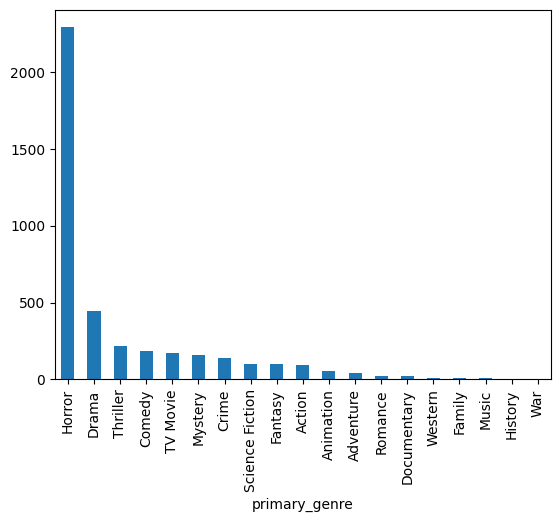

In [ ]:
# checking for value counts in primary_genre
print("Value Counts:\n", df["primary_genre"].value_counts())
df["primary_genre"].value_counts().plot(kind = "bar")